In [ ]:
!pip install pennylane --quiet

In [ ]:
import pennylane as qml
import pennylane.numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Data

We again load MNIST and perform a PCA like in the previous examples

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [ ]:
n_train_per_class = 200
n_test_per_class = 1000

In [ ]:
def filter_36(x, y, n_samples):
    keep3 = (y == 3)
    keep6 = (y == 6)
    x = np.concatenate((x[keep3][:n_samples], x[keep6][:n_samples]))
    y = np.concatenate((y[keep3][:n_samples], y[keep6][:n_samples]))
    y = y == 3
    y = 2*y - 1
    return shuffle(x, y, random_state = 0)

In [ ]:
x_train, y_train = filter_36(x_train, y_train, n_train_per_class )
x_test, y_test = filter_36(x_test, y_test, n_test_per_class )

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 400
Number of filtered test examples: 1958


In [ ]:
n_features = 4

In [ ]:
pca = PCA(n_components=n_features)

x_train = pca.fit_transform(x_train.reshape(-1, 28 * 28))
x_test = pca.transform(x_test.reshape(-1, 28 * 28))

In [ ]:
norm = np.max(x_train)

x_train = x_train/norm*2*np.pi
x_test = x_test/norm*2*np.pi

## Data Re-uploading Circuit (DRC)

In [ ]:
dev = qml.device('lightning.qubit', wires=1)

In [ ]:
def layer(data, params):
    phi1 = data[:3]*params[:3]+params[3:6]
    qml.Rot(phi1[0],phi1[1],phi1[2],wires=0)
    phi2 = data[3:6]*params[6:9]+params[9:12]
    qml.Rot(phi2[0],phi2[1],phi2[2],wires=0)

In [ ]:
layers = 8

In [ ]:
@qml.qnode(dev)
def classifier(data, params):
    for i in range(layers):
        layer(data, params[i*12:(i+1)*12])
    return qml.expval(qml.PauliZ(0))

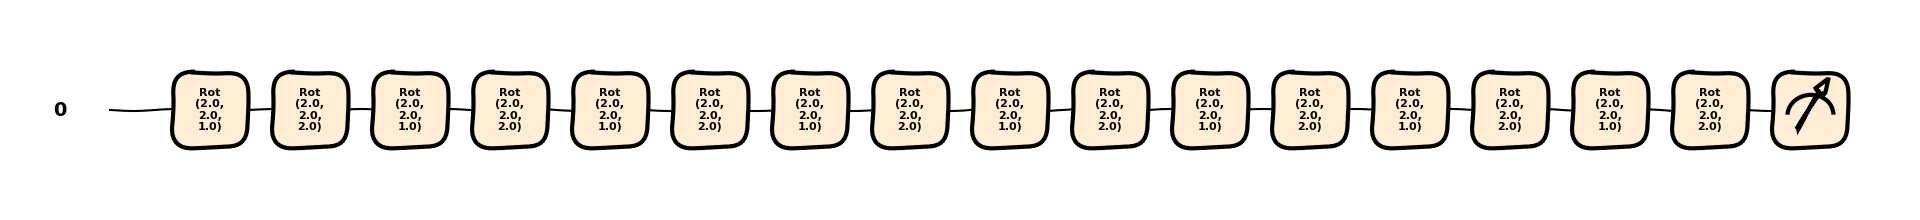

In [ ]:
qml.draw_mpl(classifier, decimals=1, style="sketch")([1,1,0,1,1,1],np.ones(layers*12))
plt.show()

## Training

In [ ]:
def loss(batch_x, batch_y, params):
  loss = 0
  for idx, x in enumerate(batch_x):
    y_pred = classifier(np.pad(x, (0,2)),params)
    loss += np.maximum(1 - batch_y[idx] * y_pred, 0)
  return loss / len(batch_x)

In [ ]:
params = np.array(np.random.uniform(size=12*layers), requires_grad=True)*np.pi

In [ ]:
def iterate_minibatches(dataX, dataY, batch_size):
    for start_idx in range(0, dataX.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield dataX[idxs], dataY[idxs]

In [ ]:
def accuracy(dataX, dataY, params):
  acc = 0
  for idx, x in enumerate(dataX):
    pred = -1 if classifier(np.pad(x, (0,2)), params) < 0 else 1
    if pred == dataY[idx]: acc += 1
  return acc / len(dataX)

In [ ]:
epochs = 12
batch_size = 16
lr = 0.01

In [ ]:
opt = qml.AdamOptimizer(stepsize=lr)

Now we just loop over the batches of data to optimize

In [ ]:
import time
start = time.time()

for it in range(epochs):
    for j,data in enumerate(iterate_minibatches(x_train, y_train, batch_size=batch_size)):
        Xbatch, Ybatch = data
        cost_fn = lambda p: loss(Xbatch, Ybatch, p)
        params = opt.step(cost_fn, params)
        print(j, end="\r")

    loss_val = loss(x_train, y_train, params)
    acc = accuracy(x_train, y_train, params)

    print(f"Epoch: {it} | Loss: {loss_val:.3} | acc: {acc:.3} ")
    print("____")

end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

Epoch: 0 | Loss: 0.887 | acc: 0.603 
____
Epoch: 1 | Loss: 0.807 | acc: 0.662 
____
Epoch: 2 | Loss: 0.76 | acc: 0.677 
____
Epoch: 3 | Loss: 0.729 | acc: 0.675 
____
Epoch: 4 | Loss: 0.708 | acc: 0.7 
____
Epoch: 5 | Loss: 0.69 | acc: 0.723 
____
Epoch: 6 | Loss: 0.677 | acc: 0.718 
____
Epoch: 7 | Loss: 0.669 | acc: 0.735 
____
Epoch: 8 | Loss: 0.663 | acc: 0.738 
____
Epoch: 9 | Loss: 0.659 | acc: 0.745 
____
Epoch: 10 | Loss: 0.655 | acc: 0.743 
____
Epoch: 11 | Loss: 0.652 | acc: 0.745 
____
Time for 12 epochs: 4319.023233890533


Try to experiment with the number of layers and see how it impacts the performance !